# 1. Données équipes par match

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# uploader le kaggle.json préalablement récupéré
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"landryt","key":"81dd51010c8e2b2934781021f134e70d"}'}

In [ ]:
# Créer un dossier kaggle
! mkdir ~/.kaggle
# Copie le fichier kaggle.json dans le dossier kaggle
! cp kaggle.json ~/.kaggle/
# Change les permisions du fichier kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
# téléchargement des données
# données kaggle https://www.kaggle.com/shubhmamp/english-premier-league-match-data
! kaggle datasets download -d shubhmamp/english-premier-league-match-data

# données kaggle https://www.kaggle.com/ayotomiwasalau/club-football-event-data
! kaggle datasets download -d ayotomiwasalau/club-football-event-data

english-premier-league-match-data.zip: Skipping, found more recently modified local copy (use --force to force download)
club-football-event-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# creation d'un folder dataset (si celui ci existe déjà, changer le nom dataset ou ignorer cette cellule si ce sont les mêmes données)
# dans le drive, et extraction des données
! mkdir '/content/drive/My Drive/dataset'
! unzip english-premier-league-match-data.zip -d '/content/drive/My Drive/dataset'
! unzip club-football-event-data.zip -d '/content/drive/My Drive/dataset'

mkdir: cannot create directory ‘/content/drive/My Drive/dataset’: File exists
Archive:  english-premier-league-match-data.zip
replace /content/drive/My Drive/dataset/datafile/season14-15/season_match_stats.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/drive/My Drive/dataset/datafile/season14-15/season_match_stats.json  
  inflating: /content/drive/My Drive/dataset/datafile/season14-15/season_stats.json  
  inflating: /content/drive/My Drive/dataset/datafile/season15-16/season_match_stats.json  
  inflating: /content/drive/My Drive/dataset/datafile/season15-16/season_stats.json  
  inflating: /content/drive/My Drive/dataset/datafile/season16-17/season_match_stats.json  
  inflating: /content/drive/My Drive/dataset/datafile/season16-17/season_stats.json  
  inflating: /content/drive/My Drive/dataset/datafile/season17-18/season_match_stats.json  
  inflating: /content/drive/My Drive/dataset/datafile/season17-18/season_stats.json  
  inflating: /content/drive/My Drive

In [4]:
import json
import math
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
team_stats_14_15_json = json.load(open('/content/drive/My Drive/dataset/datafilev2/datafile/season14-15/season_stats.json'))
team_stats_15_16_json = json.load(open('/content/drive/My Drive/dataset/datafilev2/datafile/season15-16/season_stats.json'))
team_stats_16_17_json = json.load(open('/content/drive/My Drive/dataset/datafilev2/datafile/season16-17/season_stats.json'))
team_stats_17_18_json = json.load(open('/content/drive/My Drive/dataset/datafilev2/datafile/season17-18/season_stats.json'))

match_stats_14_15_json = json.load(open('/content/drive/My Drive/dataset/datafilev2/datafile/season14-15/season_match_stats.json'))
match_stats_15_16_json = json.load(open('/content/drive/My Drive/dataset/datafilev2/datafile/season15-16/season_match_stats.json'))
match_stats_16_17_json = json.load(open('/content/drive/My Drive/dataset/datafilev2/datafile/season16-17/season_match_stats.json'))
match_stats_17_18_json = json.load(open('/content/drive/My Drive/dataset/datafilev2/datafile/season17-18/season_match_stats.json'))

In [6]:
def team_stats(json, teamloc):
    
    IsAway = 0 if teamloc == 'home' else 1 if teamloc == 'away' else None

    stats = pd.DataFrame()

    # creation d'une colonne pour les arrays contenant les id des joueurs initialisée à 0
    # si non créée à l'avance la méthode at ne marche pas et étant donné que c'est un array, il semblerait qu'il faille 
    # utiliser la méthode at en combinaison avec le type object
    
    row = 0
    for match_id, infos_match in json.items():
        stats.loc[row, 'match_id'] = match_id
        
        home = dict(list(infos_match.values())[IsAway])
        for column, team_info in home['team_details'].items():
            stats.loc[row, column] = team_info
        if IsAway == 0:
          stats.loc[row, 'time'] = None
          stats.loc[row, 'season'] = None

        for column, team_stat in home['aggregate_stats'].items():
            stats.loc[row, column] = team_stat
       
        row += 1
    
    stats['date'] = pd.to_datetime(stats['date'], dayfirst=True)
    stats = stats.sort_values(by=['date', 'match_id'])
    stats = stats.reset_index(drop=True)
    
    stats['team_rating'] = stats['team_rating'].astype(float)
    
    for column in stats.columns[6 - IsAway:]:
        stats[column] = stats[column].astype(float)
    
    stats['accurate_pass_rate'] = 100 * stats['accurate_pass'] / stats['total_pass']
       
    # regroupement des tirs marqués
    stats['goal_total'] = stats.fillna(0)['att_goal_high_left'] + stats.fillna(0)['att_goal_high_centre'] + stats.fillna(0)['att_goal_high_right'] + stats.fillna(0)['att_goal_low_left'] + stats.fillna(0)['att_goal_low_centre'] + stats.fillna(0)['att_goal_low_right']
    stats['goal_left'] = stats.fillna(0)['att_goal_high_left'] + stats.fillna(0)['att_goal_low_left']
    stats['goal_right'] = stats.fillna(0)['att_goal_high_right'] + stats.fillna(0)['att_goal_low_right']
    stats['goal_centre'] = stats.fillna(0)['att_goal_high_centre'] + stats.fillna(0)['att_sv_low_centre']
    stats['goal_high'] = stats.fillna(0)['att_goal_high_left'] + stats.fillna(0)['att_goal_high_centre'] + stats.fillna(0)['att_goal_high_right']
    stats['goal_low'] = stats.fillna(0)['att_goal_low_left'] + stats.fillna(0)['att_goal_low_centre'] + stats.fillna(0)['att_goal_low_right']

    stats['goal_total_but_low_centre'] = stats.fillna(0)['att_goal_high_left'] + stats.fillna(0)['att_goal_high_centre'] + stats.fillna(0)['att_goal_high_right'] + stats.fillna(0)['att_goal_low_left'] + stats.fillna(0)['att_goal_low_right']
    stats['goal_high_left_or_right'] = stats.fillna(0)['att_goal_high_left'] + stats.fillna(0)['att_goal_high_right']
    stats['goal_low_left_or_right'] = stats.fillna(0)['att_goal_low_left'] + stats.fillna(0)['att_goal_low_right']
    stats['goal_left_or_right'] = stats.fillna(0)['goal_high_left_or_right'] + stats.fillna(0)['goal_low_left_or_right']


    # regroupement des tirs sauvés
    stats['sv_total'] = stats.fillna(0)['att_sv_high_left'] + stats.fillna(0)['att_sv_high_centre'] + stats.fillna(0)['att_sv_high_right'] + stats.fillna(0)['att_sv_low_left'] + stats.fillna(0)['att_sv_low_centre'] + stats.fillna(0)['att_sv_low_right']
    stats['sv_left'] = stats.fillna(0)['att_sv_high_left'] + stats.fillna(0)['att_sv_low_left']
    stats['sv_right'] = stats.fillna(0)['att_sv_high_right'] + stats.fillna(0)['att_sv_low_right']
    stats['sv_centre'] = stats.fillna(0)['att_sv_high_centre'] + stats.fillna(0)['att_sv_low_centre']
    stats['sv_high'] = stats.fillna(0)['att_sv_high_left'] + stats.fillna(0)['att_sv_high_centre'] + stats.fillna(0)['att_sv_high_right']
    stats['sv_low'] = stats.fillna(0)['att_sv_low_left'] + stats.fillna(0)['att_sv_low_centre'] + stats.fillna(0)['att_sv_low_right']

    stats['sv_total_but_low_centre'] = stats.fillna(0)['att_sv_high_left'] + stats.fillna(0)['att_sv_high_centre'] + stats.fillna(0)['att_sv_high_right'] + stats.fillna(0)['att_sv_low_left'] + stats.fillna(0)['att_sv_low_right']
    stats['sv_high_left_or_right'] = stats.fillna(0)['att_sv_high_left'] + stats.fillna(0)['att_sv_high_right']
    stats['sv_low_left_or_right'] = stats.fillna(0)['att_sv_low_left'] + stats.fillna(0)['att_sv_low_right']
    stats['sv_left_or_right'] = stats.fillna(0)['sv_high_left_or_right'] + stats.fillna(0)['sv_low_left_or_right']


    # regroupement des tirs cadrés
    stats['ontarget_total'] = stats.fillna(0)['goal_total'] + stats.fillna(0)['sv_total']
    stats['ontarget_left'] = stats.fillna(0)['goal_left'] + stats.fillna(0)['sv_left']
    stats['ontarget_right'] = stats.fillna(0)['goal_right'] + stats.fillna(0)['sv_right']
    stats['ontarget_centre'] = stats.fillna(0)['goal_centre'] + stats.fillna(0)['sv_centre']
    stats['ontarget_high'] = stats.fillna(0)['goal_high'] + stats.fillna(0)['sv_high']
    stats['ontarget_low'] = stats.fillna(0)['goal_low'] + stats.fillna(0)['sv_low']

    stats['ontarget_total_but_low_centre'] = stats.fillna(0)['goal_total_but_low_centre'] + stats.fillna(0)['sv_total_but_low_centre']
    stats['ontarget_high_left_or_right'] = stats.fillna(0)['goal_high_left_or_right'] + stats.fillna(0)['sv_high_left_or_right']
    stats['ontarget_low_left_or_right'] = stats.fillna(0)['goal_low_left_or_right'] + stats.fillna(0)['sv_low_left_or_right']
    stats['ontarget_left_or_right'] = stats.fillna(0)['ontarget_high_left_or_right'] + stats.fillna(0)['ontarget_low_left_or_right']


    # regroupement des tirs manqués
    stats['miss_total'] = stats.fillna(0)['att_miss_left'] + stats.fillna(0)['att_miss_right'] + stats.fillna(0)['att_miss_high_left'] + stats.fillna(0)['att_miss_high_right'] + stats.fillna(0)['att_post_left'] + stats.fillna(0)['att_post_right'] + stats.fillna(0)['att_post_high']
    stats['miss_left'] = stats.fillna(0)['att_miss_left'] + stats.fillna(0)['att_miss_high_left'] + stats.fillna(0)['att_post_left']
    stats['miss_right'] = stats.fillna(0)['att_miss_right'] + stats.fillna(0)['att_miss_high_right'] + stats.fillna(0)['att_post_right']
    stats['miss_high'] = stats.fillna(0)['att_miss_high_left'] + stats.fillna(0)['att_miss_high_right'] + stats.fillna(0)['att_post_high']
    stats['miss_low'] = stats.fillna(0)['att_miss_left'] + stats.fillna(0)['att_miss_right']

    stats['miss_total_but_low_centre'] = stats.fillna(0)['miss_total']
    stats['miss_high_left_or_right'] = stats.fillna(0)['att_miss_high_left'] + stats.fillna(0)['att_miss_high_right']
    stats['miss_low_left_or_right'] = stats['miss_low']
    stats['miss_left_or_right'] = stats.fillna(0)['miss_high_left_or_right'] + stats.fillna(0)['miss_low_left_or_right']


    # regroupement des tirs
    stats['att_total'] = stats.fillna(0)['goal_total'] + stats.fillna(0)['sv_total'] + stats.fillna(0)['miss_total']
    stats['att_left'] = stats.fillna(0)['goal_left'] + stats.fillna(0)['sv_left'] + stats.fillna(0)['miss_left']
    stats['att_right'] = stats.fillna(0)['goal_right'] + stats.fillna(0)['sv_right'] + stats.fillna(0)['miss_right']
    stats['att_centre'] = stats.fillna(0)['goal_centre'] + stats.fillna(0)['sv_centre']
    stats['att_high'] = stats.fillna(0)['goal_high'] + stats.fillna(0)['sv_high'] + stats.fillna(0)['miss_high']
    stats['att_low'] = stats.fillna(0)['goal_low'] + stats.fillna(0)['sv_low'] + stats.fillna(0)['miss_low']

    stats['att_total_but_low_centre'] = stats.fillna(0)['goal_total_but_low_centre'] + stats.fillna(0)['sv_total_but_low_centre'] + stats.fillna(0)['miss_total_but_low_centre']
    stats['att_high_left_or_right'] = stats.fillna(0)['goal_high_left_or_right'] + stats.fillna(0)['sv_high_left_or_right'] + stats.fillna(0)['miss_high_left_or_right']
    stats['att_low_left_or_right'] = stats.fillna(0)['goal_low_left_or_right'] + stats.fillna(0)['sv_low_left_or_right'] + stats.fillna(0)['miss_low_left_or_right']
    stats['att_left_or_right'] = stats.fillna(0)['att_high_left_or_right'] + stats.fillna(0)['att_low_left_or_right']

    
    stats['total_pass_group'] = pd.cut(x = stats['total_pass'], bins = np.arange(0, 100 * ((stats['total_pass'].max() // 100) + 2), 100), labels = [str(int(i)) + str('-') + str(int(i + 100)) for i in np.arange(0, 100 * ((stats['total_pass'].max() // 100) + 1), 100)])
    stats['possession_percentage_group'] = pd.cut(x = stats['possession_percentage'], bins = [0, 30, 35, 40, 45, 50, 55, 60, 65, 70, 100], labels = ['<30%', '30%-35%', '35%-40%', '40%-45%', '45%-50%', '50%-55%', '55%-60%', '60%-65%', '65%-70%', '>70%'])
    stats['possession_percentage_group'] = stats['possession_percentage_group'].cat.add_categories(0)

    stats['accurate_pass_rate_group'] = pd.cut(x = stats['accurate_pass_rate'], bins = [0, 70, 75, 80, 85, 100], labels = ['<70%', '70%-75%', '75%-80%', '80%-85%', '>85%'])
    stats['accurate_pass_rate_group'] = stats['accurate_pass_rate_group'].cat.add_categories(0)

    return stats

In [7]:
def match_results(json):
    stats = pd.DataFrame()
    
    stats = pd.DataFrame.from_dict(json, orient='index')
    
    return stats

In [8]:
team_stats_home = {'season_14_15': team_stats(team_stats_14_15_json, 'home').add_prefix('home_'), 
                   'season_15_16': team_stats(team_stats_15_16_json, 'home').add_prefix('home_'), 
                   'season_16_17': team_stats(team_stats_16_17_json, 'home').add_prefix('home_'),  
                   'season_17_18': team_stats(team_stats_17_18_json, 'home').add_prefix('home_')}

team_stats_away = {'season_14_15': team_stats(team_stats_14_15_json, 'away').add_prefix('away_'), 
                   'season_15_16': team_stats(team_stats_15_16_json, 'away').add_prefix('away_'), 
                   'season_16_17': team_stats(team_stats_16_17_json, 'away').add_prefix('away_'),  
                   'season_17_18': team_stats(team_stats_17_18_json, 'away').add_prefix('away_')}

match_results = {'season_14_15': match_results(match_stats_14_15_json), 
                 'season_15_16': match_results(match_stats_15_16_json), 
                 'season_16_17': match_results(match_stats_16_17_json),  
                 'season_17_18': match_results(match_stats_17_18_json)}

In [9]:
# ajout de la saison des données home
team_stats_home['season_14_15']['S'] = '2014-2015'
team_stats_home['season_15_16']['S'] = '2015-2016'
team_stats_home['season_16_17']['S'] = '2016-2017'
team_stats_home['season_17_18']['S'] = '2017-2018'

In [10]:
# concatenation pour toutes les données home
df_home = pd.concat([team_stats_home['season_14_15'],team_stats_home['season_15_16'],team_stats_home['season_16_17'],team_stats_home['season_17_18']])

# concatenation pour toutes les données away
df_away = pd.concat([team_stats_away['season_14_15'],team_stats_away['season_15_16'],team_stats_away['season_16_17'],team_stats_away['season_17_18']])

# concatenation pour toutes les données match
df_match = pd.concat([match_results['season_14_15'],match_results['season_15_16'],match_results['season_16_17'],match_results['season_17_18']])

In [11]:
df_home.head()

,home_match_id,home_team_id,home_team_name,home_team_rating,home_date,home_time,home_season,home_att_goal_low_left,home_won_contest,home_possession_percentage,home_total_throws,home_att_miss_high_left,home_blocked_scoring_att,home_total_scoring_att,home_att_sv_low_left,home_total_tackle,home_att_miss_high_right,home_aerial_won,home_att_miss_right,home_att_sv_low_centre,home_aerial_lost,home_accurate_pass,home_total_pass,home_won_corners,home_shot_off_target,home_ontarget_scoring_att,home_goals,home_att_miss_left,home_fk_foul_lost,home_att_sv_low_right,home_att_goal_low_centre,home_att_sv_high_left,home_total_offside,home_att_goal_high_left,home_att_goal_low_right,home_att_miss_high,home_att_sv_high_centre,home_att_post_high,home_post_scoring_att,home_att_sv_high_right,...,home_sv_centre,home_sv_high,home_sv_low,home_sv_total_but_low_centre,home_sv_high_left_or_right,home_sv_low_left_or_right,home_sv_left_or_right,home_ontarget_total,home_ontarget_left,home_ontarget_right,home_ontarget_centre,home_ontarget_high,home_ontarget_low,home_ontarget_total_but_low_centre,home_ontarget_high_left_or_right,home_ontarget_low_left_or_right,home_ontarget_left_or_right,home_miss_total,home_miss_left,home_miss_right,home_miss_high,home_miss_low,home_miss_total_but_low_centre,home_miss_high_left_or_right,home_miss_low_left_or_right,home_miss_left_or_right,home_att_total,home_att_left,home_att_right,home_att_centre,home_att_high,home_att_low,home_att_total_but_low_centre,home_att_high_left_or_right,home_att_low_left_or_right,home_att_left_or_right,home_total_pass_group,home_possession_percentage_group,home_accurate_pass_rate_group,S
0,829513,13,Arsenal,7.015000,2014-08-16,NaN,NaN,1.0,12.0,76.0,21.0,1.0,3.0,14.0,2.0,26.0,1.0,23.0,1.0,1.0,17.0,640.0,730.0,9.0,5.0,6.0,2.0,2.0,13.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,4.0,3.0,0.0,3.0,3.0,6.0,3.0,1.0,2.0,0.0,6.0,4.0,0.0,4.0,4.0,5.0,3.0,2.0,2.0,3.0,5.0,2.0,3.0,5.0,11.0,6.0,3.0,2.0,2.0,9.0,9.0,2.0,7.0,9.0,700-800,>70%,>85%,2014-2015
1,829515,14,Leicester,6.714286,2014-08-16,NaN,NaN,NaN,6.0,36.7,12.0,NaN,3.0,11.0,NaN,13.0,NaN,27.0,2.0,NaN,14.0,265.0,344.0,3.0,5.0,3.0,2.0,1.0,16.0,1.0,NaN,NaN,NaN,NaN,2.0,2.0,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,3.0,0.0,3.0,0.0,0.0,3.0,3.0,0.0,3.0,3.0,3.0,1.0,2.0,0.0,3.0,3.0,0.0,3.0,3.0,6.0,1.0,5.0,0.0,0.0,6.0,6.0,0.0,6.0,6.0,300-400,35%-40%,75%-80%,2014-2015
2,829517,32,Manchester United,6.707143,2014-08-16,NaN,NaN,1.0,13.0,59.6,29.0,NaN,4.0,14.0,1.0,13.0,NaN,20.0,1.0,3.0,10.0,482.0,558.0,4.0,5.0,5.0,1.0,2.0,14.0,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,1.0,1.0,NaN,...,3.0,0.0,4.0,1.0,0.0,1.0,1.0,5.0,2.0,0.0,6.0,0.0,5.0,2.0,0.0,2.0,2.0,4.0,2.0,1.0,1.0,3.0,4.0,0.0,3.0,3.0,9.0,4.0,1.0,6.0,1.0,8.0,6.0,0.0,5.0,5.0,500-600,55%-60%,>85%,2014-2015
3,829519,171,Queens Park Rangers,6.715000,2014-08-16,NaN,NaN,NaN,8.0,51.0,22.0,NaN,6.0,19.0,1.0,14.0,NaN,30.0,5.0,3.0,15.0,296.0,383.0,8.0,7.0,6.0,NaN,2.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,...,4.0,2.0,4.0,3.0,1.0,1.0,2.0,6.0,1.0,1.0,7.0,2.0,4.0,3.0,1.0,1.0,2.0,7.0,2.0,5.0,0.0,7.0,7.0,0.0,7.0,7.0,13.0,3.0,6.0,7.0,2.0,11.0,10.0,1.0,8.0,9.0,300-400,50%-55%,75%-80%,2014-2015
4,829520,96,Stoke,6.799231,2014-08-16,NaN,NaN,NaN,9.0,63.1,36.0,NaN,6.0,12.0,2.0,27.0,NaN,30.0,1.0,NaN,9.0,432.0,517.0,2.0,4.0,2.0,NaN,2.0,14.0,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,0.0,0.0,2.0,2.0,0.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,2.0,2.0,0.0,2.0,2.0,3.0,2.0,1.0,0.0,3.0,3.0,0.0,3.0,3.0,5.0,4.0,1.0,0.0,0.0,5.0,5.0,0.0,5.0,5.0,500-600,60%-65%,80%-85%,2014-2015


In [12]:
# concatenation home et away
df_merge = df_home.merge(df_away, left_on=['home_match_id'], right_on=['away_match_id'])

In [13]:
# modification des données match
df_match['D'] = pd.to_datetime(df_match['date_string'].apply(lambda x: x.split(' ')[0]))
df_match['D'] = pd.to_datetime(df_match['D'], dayfirst=True)
df_match['T'] = df_match['date_string'].apply(lambda x: x.split(' ')[1])
df_match = df_match.reset_index()
df_match = df_match.rename(columns = {'index' : 'match_id'})
df_score = df_match.loc[:, ['match_id', 'D', 'T']]

In [14]:
df_merge = df_merge.rename(columns={'home_match_id': 'match_id', 'home_date': 'date'})
df_merge = df_merge.merge(right = df_score, on = 'match_id')
df_merge['date'] = pd.to_datetime(df_merge['date'], dayfirst=True)

In [15]:
# les NaN dans le dataset sont équivalents à 0
df_merge = df_merge.fillna(0)

In [16]:
df_merge.loc[df_merge['home_goal_total'] != df_merge['home_goals'], ['home_team_name', 'away_team_name', 'date', 'home_goal_total', 'home_goals']]

,home_team_name,away_team_name,date,home_goal_total,home_goals
36,Sunderland,Tottenham,2014-09-13,1.0,2.0
53,Hull,Manchester City,2014-09-27,1.0,2.0
69,West Ham,Queens Park Rangers,2014-10-05,1.0,2.0
75,Southampton,Sunderland,2014-10-18,5.0,8.0
77,Queens Park Rangers,Liverpool,2014-10-19,1.0,2.0
...,...,...,...,...,...
1414,Leicester,Stoke,2018-02-24,0.0,1.0
1430,Chelsea,Crystal Palace,2018-03-10,1.0,2.0
1431,Everton,Brighton,2018-03-10,1.0,2.0
1455,Brighton,Huddersfield,2018-04-07,0.0,1.0


In [17]:
# suppression de variables répétitives
df_merge['home_time'] = df_merge['T']
df_merge['home_season'] = df_merge['S']
df_merge = df_merge.rename(columns = {"home_season": "season", "home_time": "time"})
df_merge = df_merge.drop(['away_match_id', 'away_date', 'T', 'S', 'home_ontarget_scoring_att', 'away_ontarget_scoring_att'], axis = 1)

# 2. Cotes par match

In [18]:
! pip install datapackage

     |████████████████████████████████| 85 kB 2.7 MB/s 
     |████████████████████████████████| 72 kB 545 kB/s 
     |████████████████████████████████| 68 kB 7.0 MB/s 
     |████████████████████████████████| 45 kB 3.7 MB/s 
     |████████████████████████████████| 126 kB 48.9 MB/s 
     |████████████████████████████████| 131 kB 64.2 MB/s 
     |████████████████████████████████| 242 kB 58.7 MB/s 
     |████████████████████████████████| 8.1 MB 30.9 MB/s 
     |████████████████████████████████| 79 kB 7.1 MB/s 
     |████████████████████████████████| 127 kB 44.3 MB/s 
  Created wheel for linear-tsv: filename=linear_tsv-1.1.0-py3-none-any.whl size=7399 sha256=d5f3cb0312e5ff6fa5d36c49cb114680e44bbc8866c003c428af4c08b2513d0a
  Stored in directory: /root/.cache/pip/wheels/dd/0a/62/49ee84fab92057fb3e303fb1a59e75ccac6899b417f441305a
  Created wheel for unicodecsv: filename=unicodecsv-0.14.1-py3-none-any.whl size=10765 sha256=5b73779497dfb874929bbb02e1365c6c50bb72d28289487a3a9ca07be45ceb7c
  Store

In [19]:
import datapackage

In [20]:
#utilisation du process indiqué sur le site des données

data_url = 'https://datahub.io/sports-data/english-premier-league/datapackage.json'

# to load Data Package into storage
package = datapackage.Package(data_url)

# to load only tabular data
resources = package.resources

cotes_1415 = pd.read_csv(resources[5].descriptor['path'])
cotes_1516 = pd.read_csv(resources[4].descriptor['path'])
cotes_1617 = pd.read_csv(resources[3].descriptor['path']) 
cotes_1718 = pd.read_csv(resources[2].descriptor['path'])

In [21]:
df_cotes = pd.concat([cotes_1415, cotes_1516, cotes_1617, cotes_1718])
df_cotes = df_cotes.reset_index()

In [22]:
def bookmaker_results(bookmaker_name):
  
  results = []
  
  for i in range(len(df_cotes[bookmaker_name + 'H'])):
    if (df_cotes.loc[i, [bookmaker_name+'H', bookmaker_name + 'D', bookmaker_name + 'A']].min() == df_cotes[bookmaker_name + 'H'][i]) & (df_cotes[bookmaker_name + 'H'][i] == df_cotes[bookmaker_name + 'A'][i]):
        results.append('D')
    elif df_cotes.loc[i, [bookmaker_name+'H', bookmaker_name + 'D', bookmaker_name + 'A']].min() == df_cotes[bookmaker_name + 'H'][i]:
      results.append('H')
    elif df_cotes.loc[i, [bookmaker_name+'H', bookmaker_name + 'D', bookmaker_name + 'A']].min() == df_cotes[bookmaker_name + 'D'][i]:
        results.append('D')
    elif df_cotes.loc[i, [bookmaker_name+'H', bookmaker_name + 'D', bookmaker_name + 'A']].min() == df_cotes[bookmaker_name + 'A'][i]:
        results.append('A')
  
  return results

In [23]:
# création du tableau croisé par bookmaker
bookmaker_list = ['B365', 'BW', 'IW', 'LB', 'PS', 'WH', 'SJ', 'VC']

for i in bookmaker_list:
  df_cotes2 = df_cotes.dropna(subset=[i + 'H', i + 'D', i + 'A'])
  df_cotes2[i + 'R'] = bookmaker_results(i)
  df_cotes2[i + 'R'] = pd.Categorical(values = df_cotes2[i + 'R'], categories = ['H', 'D', 'A'])
  df_cotes2['FTR'] = pd.Categorical(df_cotes2['FTR'], categories=['H', 'D', 'A'])
  display(pd.crosstab(df_cotes2[i + 'R'], df_cotes2['FTR'], dropna = False))

FTR,H,D,A
B365R,,,
H,572,269,199
D,7,4,2
A,110,110,247


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

FTR,H,D,A
BWR,,,
H,571,265,196
D,5,5,5
A,113,113,246


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

FTR,H,D,A
IWR,,,
H,567,264,195
D,22,20,19
A,100,99,233


FTR,H,D,A
LBR,,,
H,573,269,197
D,8,4,7
A,108,110,244


FTR,H,D,A
PSR,,,
H,576,273,202
D,1,1,0
A,112,109,246


FTR,H,D,A
WHR,,,
H,568,266,194
D,8,13,10
A,113,104,244


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

FTR,H,D,A
SJR,,,
H,12,7,8
D,0,1,0
A,0,6,6


FTR,H,D,A
VCR,,,
H,574,270,199
D,4,2,4
A,111,111,245


In [24]:
# je laisse la colonne d'origine pour verifications ulterieures
df_cotes = df_cotes.rename(columns = {'Date' : 'date'})
df_cotes['date'] = df_cotes['date'].apply(lambda x: pd.to_datetime(x, dayfirst=True))
df_cotes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1520 entries, 0 to 1519
Data columns (total 69 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   index     1520 non-null   int64         
 1   Div       1520 non-null   object        
 2   date      1520 non-null   datetime64[ns]
 3   HomeTeam  1520 non-null   object        
 4   AwayTeam  1520 non-null   object        
 5   FTHG      1520 non-null   int64         
 6   FTAG      1520 non-null   int64         
 7   FTR       1520 non-null   object        
 8   HTHG      1520 non-null   int64         
 9   HTAG      1520 non-null   int64         
 10  HTR       1520 non-null   object        
 11  Referee   1520 non-null   object        
 12  HS        1520 non-null   int64         
 13  AS        1520 non-null   int64         
 14  HST       1520 non-null   int64         
 15  AST       1520 non-null   int64         
 16  HF        1520 non-null   int64         
 17  AF        1520

# 3. Jointure données matches et cotes

In [25]:
old_names = sorted(df_cotes['HomeTeam'].unique())
new_names = sorted(df_merge['home_team_name'].unique())

In [26]:
df_cotes['HomeTeam'] = df_cotes['HomeTeam'].replace(old_names, new_names)
df_cotes['AwayTeam'] = df_cotes['AwayTeam'].replace(old_names, new_names)

In [27]:
df_stats_cotes = df_merge.merge(df_cotes, left_on = ['date', 'home_team_name', 'away_team_name'], right_on = ['date', 'HomeTeam', 'AwayTeam'])

In [28]:
def best_odd(result):
  
  bookmaker_list = ['B365', 'BW', 'IW', 'LB', 'PS', 'WH', 'SJ', 'VC', 'PSC']
  best = []
  
  for i in range(len(df_stats_cotes)):
    odds = []
    for j in bookmaker_list:
      odds.append(df_stats_cotes.loc[i, j+result])
    best.append(max(odds))
  
  return best

In [29]:
# sélection de la meilleure cote
df_stats_cotes['BestH'] = best_odd('H')
df_stats_cotes['BestD'] = best_odd('D')
df_stats_cotes['BestA'] = best_odd('A')

In [30]:
df_stats_cotes.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1520 entries, 0 to 1519
Data columns (total 264 columns):
 #   Column                              Dtype         
---  ------                              -----         
 0   match_id                            object        
 1   home_team_id                        object        
 2   home_team_name                      object        
 3   home_team_rating                    float64       
 4   date                                datetime64[ns]
 5   time                                object        
 6   season                              object        
 7   home_att_goal_low_left              float64       
 8   home_won_contest                    float64       
 9   home_possession_percentage          float64       
 10  home_total_throws                   float64       
 11  home_att_miss_high_left             float64       
 12  home_blocked_scoring_att            float64       
 13  home_total_scoring_att              float64    

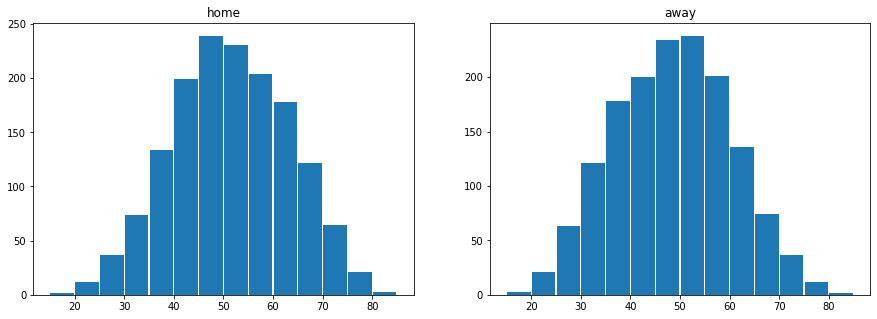

In [31]:
plt.figure(figsize=(15, 5));
team = ['home', 'away']
variable = '_possession_percentage'
step = 5

for i in range(len(team)):
  maxi = step * ((df_stats_cotes[team[i] + variable].max() // step) + 2)
  plt.subplot(1, 2, i + 1);
  plt.hist(df_stats_cotes[team[i] + variable], bins = np.arange(15, maxi, step), rwidth = 0.95);
  plt.title(team[i])


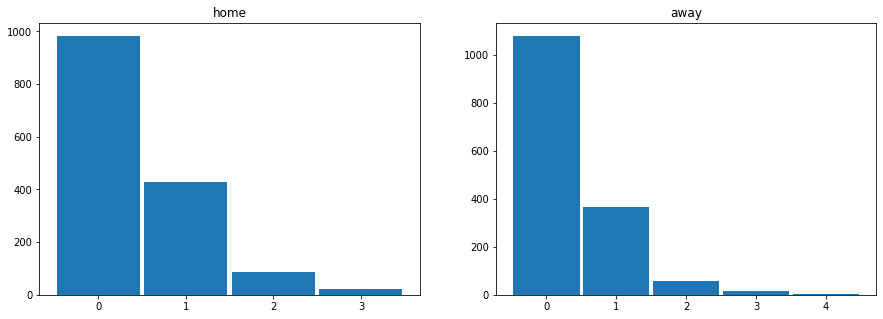

In [32]:
plt.figure(figsize=(15, 5));
team = ['home', 'away']
variable = '_att_goal_low_left'

for i in range(len(team)):
  df_stats_cotes[team[i] + variable] = df_stats_cotes[team[i] + variable].apply(lambda x: int(x))
  mini = df_stats_cotes[team[i] + variable].min()
  maxi = df_stats_cotes[team[i] + variable].max() + 1
  df = df_stats_cotes[team[i] + variable].groupby(df_stats_cotes[team[i] + variable]).count()
  plt.subplot(1, 2, i + 1);
  plt.bar(x = np.arange(mini, maxi), height = df, width = 0.95);
  plt.title(team[i])
  plt.xticks(np.arange(maxi));

In [33]:
# création du fichier csv qui peut être téléchargé à partir de colab et se retrouver en cliquant sur l'icône folder à gauche
df_stats_cotes.to_csv('/content/drive/My Drive/dataset/df_stats_cotes.csv', index = False)

# 4. Données joueurs par match

In [34]:
def players_stats(json, teamloc):
    
    IsAway = 0 if teamloc == 'home' else 1 if teamloc == 'away' else None

    stats = pd.DataFrame()
   
    row = 0
    for match_id, infos_match in json.items():
        
        home = dict(list(infos_match.values())[IsAway])
        for column, player_stat in home['Player_stats'].items():
            stats.loc[row, 'season'] = None
            stats.loc[row, 'match_id'] = match_id
            for column1, player_details in home['Player_stats'][column]['player_details'].items():
              stats.loc[row, column1] = player_details
            for column1, match_details in home['Player_stats'][column]['Match_stats'].items():
              stats.loc[row, column1] = match_details

            row+=1
    
    stats = stats.sort_values(by=['match_id'])
    stats = stats.reset_index(drop=True)

    for column in stats.columns[6:]:
        stats[column] = stats[column].astype(float)
    
    return stats

In [35]:
players_stats_home = {'season_14_15': players_stats(team_stats_14_15_json, 'home').add_prefix('home_'), 
                      'season_15_16': players_stats(team_stats_15_16_json, 'home').add_prefix('home_'), 
                      'season_16_17': players_stats(team_stats_16_17_json, 'home').add_prefix('home_'),  
                      'season_17_18': players_stats(team_stats_17_18_json, 'home').add_prefix('home_')}

players_stats_away = {'season_14_15': players_stats(team_stats_14_15_json, 'away').add_prefix('away_'), 
                      'season_15_16': players_stats(team_stats_15_16_json, 'away').add_prefix('away_'), 
                      'season_16_17': players_stats(team_stats_16_17_json, 'away').add_prefix('away_'),  
                      'season_17_18': players_stats(team_stats_17_18_json, 'away').add_prefix('away_')}


In [36]:
# concatenation pour toutes les données home
df_players_home = pd.concat([players_stats_home['season_14_15'], players_stats_home['season_15_16'], players_stats_home['season_16_17'], players_stats_home['season_17_18']])

# concatenation pour toutes les données away
df_players_away = pd.concat([players_stats_away['season_14_15'], players_stats_away['season_15_16'], players_stats_away['season_16_17'], players_stats_away['season_17_18']])

In [37]:
df_players_away.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27350 entries, 0 to 6834
Data columns (total 38 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   away_season                 0 non-null      float64
 1   away_match_id               27350 non-null  object 
 2   away_player_id              27350 non-null  object 
 3   away_player_name            27350 non-null  object 
 4   away_player_position_value  27350 non-null  object 
 5   away_player_position_info   27350 non-null  object 
 6   away_player_rating          27350 non-null  float64
 7   away_good_high_claim        981 non-null    float64
 8   away_touches                20840 non-null  float64
 9   away_saves                  1420 non-null   float64
 10  away_total_pass             20718 non-null  float64
 11  away_formation_place        27350 non-null  float64
 12  away_accurate_pass          20585 non-null  float64
 13  away_won_contest            7984

In [38]:
df_players_away.head()

,away_season,away_match_id,away_player_id,away_player_name,away_player_position_value,away_player_position_info,away_player_rating,away_good_high_claim,away_touches,away_saves,away_total_pass,away_formation_place,away_accurate_pass,away_won_contest,away_total_tackle,away_aerial_lost,away_aerial_won,away_fouls,away_yellow_card,away_total_scoring_att,away_goals,away_second_yellow,away_blocked_scoring_att,away_goal_assist,away_red_card,away_man_of_the_match,away_error_lead_to_goal,away_last_man_tackle,away_penalty_save,away_penalty_conceded,away_clearance_off_line,away_post_scoring_att,away_six_yard_block,away_att_pen_goal,away_att_pen_target,away_own_goals,away_att_pen_miss,away_att_pen_post
0,NaN,829513,7895,Julian Speroni,1,GK,6.26,2.0,35.0,4.0,29.0,1.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,829513,21571,Wayne Hennessey,5,Sub,0.00,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,829513,11668,Paddy McCarthy,5,Sub,0.00,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,829513,8466,Damien Delaney,5,Sub,6.03,NaN,5.0,NaN,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,829513,21427,Glenn Murray,5,Sub,0.00,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
# on ne conserve que les joueurs qui ont une note
df_players_home_rated = df_players_home.loc[df_players_home['home_player_rating'] > 0,:]
df_players_away_rated = df_players_away.loc[df_players_away['away_player_rating'] > 0,:]

# les NaN dans le dataset sont égaux à 0
df_players_home_rated = df_players_home_rated.fillna(0)
df_players_away_rated = df_players_away_rated.fillna(0)

In [40]:
# concatenation pour toutes les données home
#df_players_home_rated['home_season'] = df_players_home_rated['S']
#df_players_home_rated = df_players_home_rated.rename(columns={"home_season": "season", "home_match_id": "match_id"})
#df_players_home_rated = df_players_home_rated.drop('S', axis = 1)
df_players_home_rated = df_players_home_rated.rename(columns={"home_match_id": "match_id"})

# concatenation pour toutes les données away
#df_players_away_rated['away_season'] = df_players_away_rated['S']
#df_players_away_rated = df_players_away_rated.rename(columns={"away_season": "season", "away_match_id": "match_id"})
#df_players_away_rated = df_players_away_rated.drop('S', axis = 1)
df_players_away_rated = df_players_away_rated.rename(columns={"away_match_id": "match_id"})

In [41]:
# regroupement par poste
df_players_home_rated['home_player_position'] = df_players_home_rated['home_player_position_value']
df_players_home_rated['home_player_position'].replace(['1', '2', '3', '4', '5'], ['Goalkeeper', 'Defender', 'Midfielder', 'Forward', 'Substitute'], inplace = True)

df_players_away_rated['away_player_position'] = df_players_away_rated['away_player_position_value']
df_players_away_rated['away_player_position'].replace(['1', '2', '3', '4', '5'], ['Goalkeeper', 'Defender', 'Midfielder', 'Forward', 'Substitute'], inplace = True)

In [42]:
def position_rating(teamloc):
  
  output = pd.DataFrame()
  position_list = ['Goalkeeper', 'Defender', 'Midfielder', 'Forward', 'Substitute']

  if teamloc == 'home':
    df = pd.DataFrame(df_players_home_rated.groupby(['match_id', teamloc + '_player_position']).mean()[teamloc + '_player_rating'].reset_index())
  elif teamloc == 'away':
    df = pd.DataFrame(df_players_away_rated.groupby(['match_id', teamloc + '_player_position']).mean()[teamloc + '_player_rating'].reset_index())
  
  df.index = df['match_id']

  for position in position_list:
    output = pd.concat([output, df.loc[df[teamloc + '_player_position'] == position,:]], axis = 1)
    output = output.rename(columns = {teamloc + '_player_rating': teamloc + str('_') + position.lower() + '_player_rating'})
    output[teamloc + str('_') + position.lower() + '_player_rating_group'] = pd.cut(x = output[teamloc + str('_') + position.lower() + '_player_rating'], bins = [0, 6, 6.5, 7, 7.5, 8, 10], labels = ['< 6', '6 - 6.5', '6.5 - 7', '7 - 7.5', '7.5 - 8', '> 8'])
    output[teamloc + str('_') + position.lower() + '_player_rating_group'] = output[teamloc + str('_') + position.lower() + '_player_rating_group'].cat.add_categories(0)
    output = output.drop(['match_id', teamloc + '_player_position'], axis = 1)

  output = output.reset_index()
  output = output.rename(columns = {'index':'match_id'})

  
  return output

df_position_home = position_rating('home')

In [43]:
df_position_home_rating = position_rating('home')
df_position_away_rating = position_rating('away')

df_position_rating = df_position_home_rating.merge(df_position_away_rating, on = ['match_id'])
df_position_rating = df_position_rating.fillna(0)

In [44]:
df_stats_cotes = df_stats_cotes.merge(df_position_rating, on = ['match_id'])

In [45]:
df_stats_cotes.head()

,match_id,home_team_id,home_team_name,home_team_rating,date,time,season,home_att_goal_low_left,home_won_contest,home_possession_percentage,home_total_throws,home_att_miss_high_left,home_blocked_scoring_att,home_total_scoring_att,home_att_sv_low_left,home_total_tackle,home_att_miss_high_right,home_aerial_won,home_att_miss_right,home_att_sv_low_centre,home_aerial_lost,home_accurate_pass,home_total_pass,home_won_corners,home_shot_off_target,home_goals,home_att_miss_left,home_fk_foul_lost,home_att_sv_low_right,home_att_goal_low_centre,home_att_sv_high_left,home_total_offside,home_att_goal_high_left,home_att_goal_low_right,home_att_miss_high,home_att_sv_high_centre,home_att_post_high,home_post_scoring_att,home_att_sv_high_right,home_att_pen_goal,...,BbAvD,BbMxA,BbAvA,BbOU,BbMx>2.5,BbAv>2.5,BbMx<2.5,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA,BestH,BestD,BestA,home_goalkeeper_player_rating,home_goalkeeper_player_rating_group,home_defender_player_rating,home_defender_player_rating_group,home_midfielder_player_rating,home_midfielder_player_rating_group,home_forward_player_rating,home_forward_player_rating_group,home_substitute_player_rating,home_substitute_player_rating_group,away_goalkeeper_player_rating,away_goalkeeper_player_rating_group,away_defender_player_rating,away_defender_player_rating_group,away_midfielder_player_rating,away_midfielder_player_rating_group,away_forward_player_rating,away_forward_player_rating_group,away_substitute_player_rating,away_substitute_player_rating_group
0,829513,13,Arsenal,7.015000,2014-08-16,17:30:00,2014-2015,1,12.0,76.0,21.0,1.0,3.0,14.0,2.0,26.0,1.0,23.0,1.0,1.0,17.0,640.0,730.0,9.0,5.0,2.0,2.0,13.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.96,16.00,12.43,48,1.77,1.72,2.26,2.10,24,-1.50,1.81,1.78,2.20,2.10,1.29,5.90,12.75,1.30,6.5,15.00,5.81,< 6,7.277500,7 - 7.5,7.556,7.5 - 8,6.420,6 - 6.5,6.363333,6 - 6.5,6.26,6 - 6.5,6.950000,6.5 - 7,6.8125,6.5 - 7,6.825,6.5 - 7,5.946667,< 6
1,829515,14,Leicester,6.714286,2014-08-16,15:00:00,2014-2015,0,6.0,36.7,12.0,0.0,3.0,11.0,0.0,13.0,0.0,27.0,2.0,0.0,14.0,265.0,344.0,3.0,5.0,2.0,1.0,16.0,1.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,...,3.32,2.42,2.36,48,2.10,2.00,1.90,1.80,22,0.25,1.88,1.85,2.10,2.02,3.11,3.40,2.47,3.25,3.4,2.47,6.39,6 - 6.5,6.937500,6.5 - 7,6.520,6.5 - 7,7.005,7 - 7.5,6.590000,6.5 - 7,6.03,6 - 6.5,6.560000,6.5 - 7,7.0600,7 - 7.5,6.320,6 - 6.5,6.020000,6 - 6.5
2,829517,32,Manchester United,6.707143,2014-08-16,12:45:00,2014-2015,1,13.0,59.6,29.0,0.0,4.0,14.0,1.0,13.0,0.0,20.0,1.0,3.0,10.0,482.0,558.0,4.0,5.0,1.0,2.0,14.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,4.96,11.03,9.32,48,1.77,1.71,2.30,2.13,25,-1.50,2.18,2.08,1.87,1.79,1.45,4.81,8.25,1.45,5.2,11.00,5.79,< 6,7.076667,7 - 7.5,6.550,6.5 - 7,7.050,7 - 7.5,6.510000,6.5 - 7,7.34,7 - 7.5,6.785000,6.5 - 7,7.2560,7 - 7.5,6.500,6 - 6.5,6.383333,6 - 6.5
3,829519,171,Queens Park Rangers,6.715000,2014-08-16,15:00:00,2014-2015,0,8.0,51.0,22.0,0.0,6.0,19.0,1.0,14.0,0.0,30.0,5.0,3.0,15.0,296.0,383.0,8.0,7.0,0.0,2.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,3.18,3.20,3.02,46,2.52,2.36,1.65,1.58,24,0.00,1.80,1.73,2.25,2.14,2.31,3.24,3.59,2.60,3.3,3.59,6.88,6.5 - 7,7.096667,7 - 7.5,6.776,6.5 - 7,6.655,6.5 - 7,6.216667,6 - 6.5,8.92,> 8,8.013333,> 8,7.2775,7 - 7.5,6.330,6 - 6.5,6.470000,6 - 6.5
4,829520,96,Stoke,6.799231,2014-08-16,15:00:00,2014-2015,0,9.0,63.1,36.0,0.0,6.0,12.0,2.0,27.0,0.0,30.0,1.0,0.0,9.0,432.0,517.0,2.0,4.0,0.0,2.0,14.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,3.38,4.80,4.27,44,2.42,2.31,1.67,1.60,23,-0.50,1.95,1.91,2.02,1.96,2.01,3.34,4.51,2.01,3.5,4.75,5.73,< 6,7.450000,7 - 7.5,6.770,6.5 - 7,6.590,6.5 - 7,6.210000,6 - 6.5,6.30,6 - 6.5,7.087500,7 - 7.5,6.9820,6.5 - 7,6.200,6 - 6.5,6.110000,6 - 6.5


In [46]:
df_stats_cotes.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1520 entries, 0 to 1519
Data columns (total 284 columns):
 #   Column                               Dtype         
---  ------                               -----         
 0   match_id                             object        
 1   home_team_id                         object        
 2   home_team_name                       object        
 3   home_team_rating                     float64       
 4   date                                 datetime64[ns]
 5   time                                 object        
 6   season                               object        
 7   home_att_goal_low_left               int64         
 8   home_won_contest                     float64       
 9   home_possession_percentage           float64       
 10  home_total_throws                    float64       
 11  home_att_miss_high_left              float64       
 12  home_blocked_scoring_att             float64       
 13  home_total_scoring_att          

In [47]:
df_stats_cotes.to_csv('/content/drive/MyDrive/dataset/df_stats_cotes_teams.csv')